## Task B

### Importing Packages

In [1]:
import pandas as pd
import numpy as np
import string
from nltk.corpus import stopwords
from nltk import FreqDist

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Read in scraped Tweets
dfTweets = pd.read_csv('UniqueCombinedTweets.csv')

# Remove additional index column
dfTweets = dfTweets.drop(columns= 'Unnamed: 0')

### Creating and Cleaning Corpus

In [4]:
# Function to remove punctuation
def punctuation_extermination(s):
    o = str.maketrans('', '', string.punctuation)
    return str(s).translate(o)

# Removing punctation from comments
dfTweets['text'] = dfTweets['text'].apply(punctuation_extermination)

In [5]:
def build_corpus(text_col):
    """To build a text corpus by stitching all the records together.Input the text column"""
    corpus = ""
    for word in text_col:
        corpus += word
    return corpus

In [6]:
# Building the corpus
corpus = build_corpus(dfTweets['text'])

# Converting all the words into lowercase
corpus = corpus.lower()

# Removing stropwords from corpus
corpus = corpus.split()
corpusNoStop = [word for word in corpus if word not in stopwords.words("english")]

### Determining Key Issues

In [10]:
def plot_word_frequency(words, top_n=125):
    """Function to plot the word frequencies"""
    word_freq = FreqDist(words)
    labels = [element[0] for element in word_freq.most_common(top_n)]
    counts = [element[1] for element in word_freq.most_common(top_n)]
    tempDict = {"Labels": labels, "Count": counts}
    plt.figure(figsize=(15,5))
    plt.title("Most Frequent Words in the Corpus - Excluding STOPWORDS")
    plt.ylabel("Count")
    plt.xlabel("Word")
    plt.xticks(rotation=90)
    plot = sns.barplot(data= tempDict, x= "Labels", y= "Count")
    return plot

<AxesSubplot:title={'center':'Most Frequent Words in the Corpus - Excluding STOPWORDS'}, xlabel='Word', ylabel='Count'>

/usr/local/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


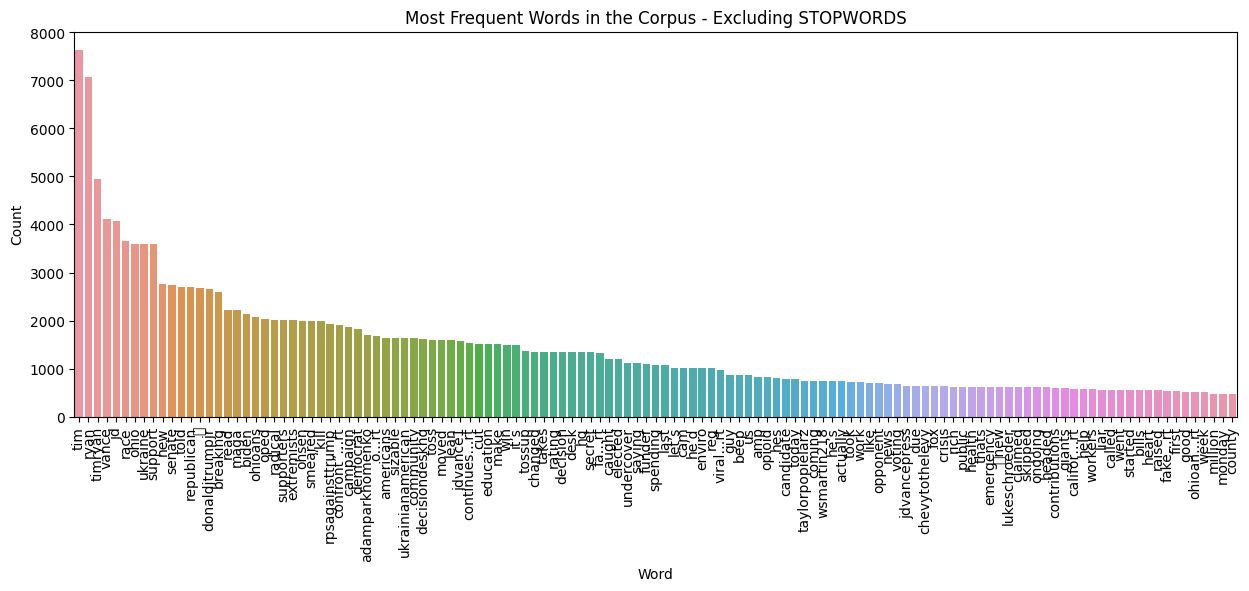

In [11]:
plot_word_frequency(corpusNoStop)

The four key issues found are: Education, Opioid (opioid crisis), Ukraine, health (healthcare).

## Task C

### Candidate Name Replacement (standardizing candidate names)

In [12]:
# Dictionary with variations of candidates' names and replacement
namesDict = {'tim': 'tim ryan', 'ryan': 'tim ryan', 'timryan': 'tim ryan', 'jd': 'jd vance', 'vance': 'jd vance'}

In [13]:
# Function to switch candidate nicknames with unified names
def candidateSwitch(x):
    t = x.split()
    for word in t:
        if word in namesDict:
            x = x.replace(word, namesDict[word])
    return x

# Switching nicknames to actual names in comments
corpusSwapped = [candidateSwitch(x) for x in corpusNoStop]
dfTweets['text'] = dfTweets['text'].apply(lambda i: i.lower())
dfTweets['text'] = dfTweets['text'].apply(lambda i: (candidateSwitch(i)))

### Lift Analysis

In [14]:
# List of candidates
candidates = ['tim ryan', 'jd vance','education', 'opioid', 'ukraine', 'health']

# List of issues
issues = ['tim ryan', 'jd vance','education', 'opioid', 'ukraine', 'health']

In [15]:
dfTweets.shape[0]

20171

In [16]:
lift_dict = pd.DataFrame(index= candidates, columns= issues)
lift_dict

,tim ryan,jd vance,education,opioid,ukraine,health
tim ryan,NaN,NaN,NaN,NaN,NaN,NaN
jd vance,NaN,NaN,NaN,NaN,NaN,NaN
education,NaN,NaN,NaN,NaN,NaN,NaN
opioid,NaN,NaN,NaN,NaN,NaN,NaN
ukraine,NaN,NaN,NaN,NaN,NaN,NaN
health,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
lift_dict = pd.DataFrame(index= candidates, columns= issues)
print 
total_shape = dfTweets.shape[0]
for i in range(len(issues)): 
    for j in range(len(candidates)):
        brand_1 = issues[i]
        brand_2 = candidates[j]
        count_1 = 0
        count_2 = 0
        count_3 = 0

        
        for txt in dfTweets.text.values:
            if brand_1 in txt and brand_2 in txt:
                count_3 = count_3 + 1
                
            elif brand_1 in txt and brand_2 not in txt:
                count_1 = count_1 + 1 
              
            elif brand_1 not in txt and brand_2 in txt:
                count_2 = count_2 + 1
                
        
        if(brand_1==brand_2):
            lift_dict[brand_1][brand_2] = 0

        else: 
            pa = count_1/total_shape
            pb = count_2/total_shape
            pab = count_3/total_shape

            if(pab!=0):
                ans = (pa*pb)/pab
            else:
                ans = 0

            if(ans!=0):
                lift_dict[brand_1][brand_2] = round(1/ans,3)
            else:
                lift_dict[brand_1][brand_2] = 0

In [18]:
lift_dict.apply

<bound method DataFrame.apply of           tim ryan   jd vance  education  opioid ukraine   health
tim ryan         0      0.997          0  48.159       0  202.945
jd vance     0.997          0  11233.352    0.47   0.973    0.016
education        0  11233.352          0       0       0        0
opioid      48.159       0.47          0       0       0        0
ukraine          0      0.973          0       0       0        0
health     202.945      0.016          0       0       0        0>

In [19]:
lift_dict.apply(pd.to_numeric).style.background_gradient(axis=0,cmap='Blues')

,tim ryan,jd vance,education,opioid,ukraine,health
tim ryan,0.000000,0.997000,0.000000,48.159000,0.000000,202.945000
jd vance,0.997000,0.000000,11233.352000,0.470000,0.973000,0.016000
education,0.000000,11233.352000,0.000000,0.000000,0.000000,0.000000
opioid,48.159000,0.470000,0.000000,0.000000,0.000000,0.000000
ukraine,0.000000,0.973000,0.000000,0.000000,0.000000,0.000000
health,202.945000,0.016000,0.000000,0.000000,0.000000,0.000000


## Sentiment Analysis

In [104]:
import re

# List of issues and candidates
listIssues = ['education', 'opioid', 'ukraine', 'health']
listCandidates = ['tim ryan', 'jd vance']
# Flattens list
def flatten(l):
    return [item for sublist in l for item in sublist]
# Pulls a window around designated words
def windowList(text,n, searchWord):
    '''Searches for text, and retrieves n words either side of the text, which are retuned seperatly'''
    word = r"\W*([\w]+)"
    groups = re.search(r'{}\W*{}{}'.format(word*n,searchWord,word*n), text).groups()
    window = []
    wordList = []
    wordList.append(searchWord)
    window.append(groups[:n])
    window.append(wordList)
    window.append(groups[n:])
    window = flatten(window)
    return window
# Finds issues with corresponding candidates, creates window around issue, and returns candidate name + window
def window(x):
    t = x.split()
    if ('tim' in t) & ('ryan' in t):
        cand = 'tim ryan'
        for word in t:
            if word in listIssues:
                window = str(cand) + ' ' + ' '.join(windowList(x, 3, str(word)))
                break
            else:
                window = ''
    elif ('jd' in t) & ('vance' in t):
        cand = 'jd vance'
        for word in t:
            if word in listIssues:
                window = str(cand) + ' ' + ' '.join(windowList(x, 3, str(word)))
                break
            else:
                window = ''
    else:
        window = ''
    return window



In [105]:
# Create new column with candidate name and window for sentiment analysis
dfTweets['window'] = dfTweets['text'].apply(lambda i: (window(i)))

In [106]:
dfTweets['window']

0                                                         
1                                                         
2                                                         
3                                                         
4                                                         
                               ...                        
20166           jd vance he d cut education and enviro reg
20167           jd vance he d cut education and enviro reg
20168    jd vance he would cut education environmental ...
20169           jd vance he d cut education and enviro reg
20170                                                     
Name: window, Length: 20171, dtype: object

In [124]:
for i in dfTweets['window']:
    print (i)
























































































































































































































































































































































jd vance what happens to ukraine one wa y



























tim ryan the ongoing public health emergency hes actually












jd vance what happens to ukraine one wa y

jd vance what happens to ukraine one wa y






































jd vance what happens to ukraine one wa y


















jd vance what happens to ukraine one wa y














jd vance what happens to ukraine one wa y






















jd vance what happens to ukraine one wa y










jd vance what happens to ukraine one wa y
























jd vance what happens to ukraine one wa y





jd vance what happens to ukraine one wa y

jd vanc

In [107]:
TR_opiod_df = pd.DataFrame()

TR_opiod_df['compound'] = [analyzer.polarity_scores(x)['compound'] for x in dfTweets['window'] if 'tim ryan' in x and 'opiod' in x ]
TR_opiod_df['neg'] = [analyzer.polarity_scores(x)['neg'] for x in dfTweets['window'] if 'tim ryan' in x and 'opiod' in x ]
TR_opiod_df['neu'] = [analyzer.polarity_scores(x)['neu'] for x in dfTweets['window'] if 'tim ryan' in x and 'opiod' in x ]
TR_opiod_df['pos'] = [analyzer.polarity_scores(x)['pos'] for x in dfTweets['window'] if 'tim ryan' in x and 'opiod' in x ]


In [108]:
TR_opiod_df

,compound,neg,neu,pos


In [109]:
TR_health_df = pd.DataFrame()

TR_health_df['compound'] = [analyzer.polarity_scores(x)['compound'] for x in dfTweets['window'] if 'tim ryan' in x and 'health' in x ]
TR_health_df['neg'] = [analyzer.polarity_scores(x)['neg'] for x in dfTweets['window'] if 'tim ryan' in x and 'health' in x ]
TR_health_df['neu'] = [analyzer.polarity_scores(x)['neu'] for x in dfTweets['window'] if 'tim ryan' in x and 'health' in x ]
TR_health_df['pos'] = [analyzer.polarity_scores(x)['pos'] for x in dfTweets['window'] if 'tim ryan' in x and 'health' in x ]


In [110]:
TR_health_df

,compound,neg,neu,pos
0,-0.3818,0.245,0.755,0.0
1,-0.3818,0.245,0.755,0.0
2,-0.3818,0.245,0.755,0.0
3,-0.3818,0.245,0.755,0.0
4,-0.3818,0.245,0.755,0.0
...,...,...,...,...
603,-0.3818,0.245,0.755,0.0
604,-0.3818,0.245,0.755,0.0
605,-0.3818,0.245,0.755,0.0
606,-0.3818,0.245,0.755,0.0


In [111]:
JD_edu_df = pd.DataFrame()

JD_edu_df['compound'] = [analyzer.polarity_scores(x)['compound'] for x in dfTweets['window'] if 'jd vance' in x and 'education' in x ]
JD_edu_df['neg'] = [analyzer.polarity_scores(x)['neg'] for x in dfTweets['window'] if 'jd vance' in x and 'education' in x ]
JD_edu_df['neu'] = [analyzer.polarity_scores(x)['neu'] for x in dfTweets['window'] if 'jd vance' in x and 'education' in x ]
JD_edu_df['pos'] = [analyzer.polarity_scores(x)['pos'] for x in dfTweets['window'] if 'jd vance' in x and 'education' in x ]


In [112]:
JD_edu_df

,compound,neg,neu,pos
0,-0.1280,0.158,0.842,0.0
1,-0.1280,0.158,0.842,0.0
2,-0.1280,0.158,0.842,0.0
3,-0.1280,0.158,0.842,0.0
4,-0.1280,0.158,0.842,0.0
...,...,...,...,...
1507,-0.2732,0.208,0.792,0.0
1508,-0.2732,0.208,0.792,0.0
1509,-0.2732,0.208,0.792,0.0
1510,-0.2732,0.208,0.792,0.0


In [113]:
JD_ukraine_df = pd.DataFrame()

JD_ukraine_df['compound'] = [analyzer.polarity_scores(x)['compound'] for x in dfTweets['window'] if 'jd vance' in x and 'ukraine' in x ]
JD_ukraine_df['neg'] = [analyzer.polarity_scores(x)['neg'] for x in dfTweets['window'] if 'jd vance' in x and 'ukraine' in x ]
JD_ukraine_df['neu'] = [analyzer.polarity_scores(x)['neu'] for x in dfTweets['window'] if 'jd vance' in x and 'ukraine' in x ]
JD_ukraine_df['pos'] = [analyzer.polarity_scores(x)['pos'] for x in dfTweets['window'] if 'jd vance' in x and 'ukraine' in x ]


In [114]:
JD_ukraine_df

,compound,neg,neu,pos
0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0
...,...,...,...,...
306,0.0,0.0,1.0,0.0
307,0.0,0.0,1.0,0.0
308,0.0,0.0,1.0,0.0
309,0.0,0.0,1.0,0.0


In [22]:
'''from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

analyzer = SentimentIntensityAnalyzer()
df = pd.DataFrame()
df['compound'] = [analyzer.polarity_scores(x)['compound'] for x in dfTweets['text']]
df['neg'] = [analyzer.polarity_scores(x)['neg'] for x in dfTweets['text']]
df['neu'] = [analyzer.polarity_scores(x)['neu'] for x in dfTweets['text']]
df['pos'] = [analyzer.polarity_scores(x)['pos'] for x in dfTweets['text']]'''

In [23]:
TR_opiod_df = pd.DataFrame()

TR_opiod_df['compound'] = [analyzer.polarity_scores(x)['compound'] for x in dfTweets['text'] if 'tim ryan' in x and 'opiod' in x ]
TR_opiod_df['neg'] = [analyzer.polarity_scores(x)['neg'] for x in dfTweets['text'] if 'tim ryan' in x and 'opiod' in x ]
TR_opiod_df['neu'] = [analyzer.polarity_scores(x)['neu'] for x in dfTweets['text'] if 'tim ryan' in x and 'opiod' in x ]
TR_opiod_df['pos'] = [analyzer.polarity_scores(x)['pos'] for x in dfTweets['text'] if 'tim ryan' in x and 'opiod' in x ]

In [24]:
TR_opiod_df

,compound,neg,neu,pos
0,-0.5106,0.177,0.823,0.000
1,-0.5106,0.146,0.799,0.055


In [25]:
TR_health_df = pd.DataFrame()

TR_health_df['compound'] = [analyzer.polarity_scores(x)['compound'] for x in dfTweets['text'] if 'tim ryan' in x and 'health' in x ]
TR_health_df['neg'] = [analyzer.polarity_scores(x)['neg'] for x in dfTweets['text'] if 'tim ryan' in x and 'health' in x ]
TR_health_df['neu'] = [analyzer.polarity_scores(x)['neu'] for x in dfTweets['text'] if 'tim ryan' in x and 'health' in x ]
TR_health_df['pos'] = [analyzer.polarity_scores(x)['pos'] for x in dfTweets['text'] if 'tim ryan' in x and 'health' in x ]


In [26]:
TR_health_df

,compound,neg,neu,pos
0,-0.3818,0.102,0.898,0.0
1,-0.3818,0.102,0.898,0.0
2,-0.3818,0.102,0.898,0.0
3,-0.3818,0.102,0.898,0.0
4,-0.3818,0.102,0.898,0.0
...,...,...,...,...
603,-0.3818,0.102,0.898,0.0
604,-0.3818,0.102,0.898,0.0
605,-0.3818,0.102,0.898,0.0
606,-0.3818,0.102,0.898,0.0


In [27]:
JD_edu_df = pd.DataFrame()

JD_edu_df['compound'] = [analyzer.polarity_scores(x)['compound'] for x in dfTweets['text'] if 'jd vance' in x and 'education' in x ]
JD_edu_df['neg'] = [analyzer.polarity_scores(x)['neg'] for x in dfTweets['text'] if 'jd vance' in x and 'education' in x ]
JD_edu_df['neu'] = [analyzer.polarity_scores(x)['neu'] for x in dfTweets['text'] if 'jd vance' in x and 'education' in x ]
JD_edu_df['pos'] = [analyzer.polarity_scores(x)['pos'] for x in dfTweets['text'] if 'jd vance' in x and 'education' in x ]


In [28]:
JD_edu_df

,compound,neg,neu,pos
0,0.2732,0.055,0.849,0.096
1,0.2732,0.055,0.849,0.096
2,0.2732,0.055,0.849,0.096
3,0.2732,0.055,0.849,0.096
4,0.2732,0.055,0.849,0.096
...,...,...,...,...
1507,-0.2732,0.087,0.913,0.000
1508,-0.2732,0.077,0.923,0.000
1509,-0.2732,0.077,0.923,0.000
1510,-0.2732,0.087,0.913,0.000


In [29]:
JD_ukraine_df = pd.DataFrame()

JD_ukraine_df['compound'] = [analyzer.polarity_scores(x)['compound'] for x in dfTweets['text'] if 'jd vance' in x and 'ukraine' in x ]
JD_ukraine_df['neg'] = [analyzer.polarity_scores(x)['neg'] for x in dfTweets['text'] if 'jd vance' in x and 'ukraine' in x ]
JD_ukraine_df['neu'] = [analyzer.polarity_scores(x)['neu'] for x in dfTweets['text'] if 'jd vance' in x and 'ukraine' in x ]
JD_ukraine_df['pos'] = [analyzer.polarity_scores(x)['pos'] for x in dfTweets['text'] if 'jd vance' in x and 'ukraine' in x ]


In [30]:
JD_ukraine_df

,compound,neg,neu,pos
0,0.7559,0.078,0.652,0.270
1,0.7559,0.078,0.652,0.270
2,0.7559,0.078,0.652,0.270
3,0.7559,0.078,0.652,0.270
4,0.7559,0.078,0.652,0.270
...,...,...,...,...
306,0.7559,0.078,0.652,0.270
307,0.7559,0.078,0.652,0.270
308,0.7559,0.078,0.652,0.270
309,0.7559,0.078,0.652,0.270


In [31]:
test

NameError: name 'test' is not defined

## Task D

In [32]:
from sklearn.manifold import MDS

mdslifts = lift_dict
mdslifts.reset_index(drop=True, inplace=True)
mds = MDS(random_state=0)
print(mdslifts)
mdslifts = mds.fit_transform(mdslifts)
mdslifts


  tim ryan   jd vance  education  opioid ukraine   health
0        0      0.997          0  48.159       0  202.945
1    0.997          0  11233.352    0.47   0.973    0.016
2        0  11233.352          0       0       0        0
3   48.159       0.47          0       0       0        0
4        0      0.973          0       0       0        0
5  202.945      0.016          0       0       0        0


/usr/local/lib/python3.10/site-packages/sklearn/manifold/_mds.py:512: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


array([[ 1941.02372764,  1871.11645371],
       [ 1247.82709787, -9464.15986233],
       [-9218.18337835,  2478.56438052],
       [ 1981.15788392,  1704.20066974],
       [ 1942.45464633,  1703.36147816],
       [ 2105.72002259,  1706.91688021]])

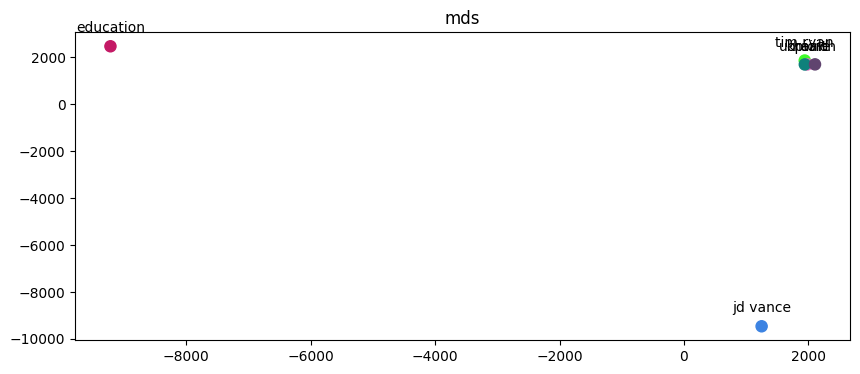

In [33]:
colors = ['#41FB29', '#3C83E2','#C41965', '#E56FC1', '#0F817B', '#60446F']

size = [64, 64, 64, 64, 64, 64] ##41FB29
fig = plt.figure(2, (10,4))
plt.scatter(mdslifts[:,0], mdslifts[:,1], s=size, c=colors)
count = 0

for x, y in zip(mdslifts[:,0], mdslifts[:,1]):
    label = "{0}".format(candidates[count])
    count += 1
    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha=('center') # horizontal alignment
    )
plt.title('mds')
plt.show()


In [34]:
import pandas as pd
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import random

"""Calculates the lift ratio from a given Pandas Dataframe for specified columns/features within the dataset
Keyword arguments:
index -- (list) object containing the items/things of interest to calculate the lift ratio on
data -- (Pandas DataFrame) object with data that has feature/column names that are contained in the 'index' argument
Return: Pandas DataFrame that displays the lift ratios for the given features
"""
def lift_ratio(index : list, data : pd.DataFrame):
    lift_dict = pd.DataFrame(index=index, columns=index)
    total_shape = data.shape[0]
    for i in range(len(index)):
        for j in range(len(index)):
            brand_1 = index[i]
            brand_2 = index[j]
            count_1 = 0
            count_2 = 0
            count_3 = 0
            
            for txt in data.comments.values:
                if brand_1 in txt and brand_2 in txt:
                    count_3 = count_3 + 1
                elif brand_1 in txt and brand_2 not in txt:
                    count_1 = count_1 + 1 
                elif brand_1 not in txt and brand_2 in txt:
                    count_2 = count_2 + 1
            
            if(brand_1==brand_2):
                lift_dict[brand_1][brand_2] = 0

            else:
                pa = count_1/total_shape
                pb = count_2/total_shape
                pab = count_3/total_shape
                ans = (pa*pb)/pab
                
                lift_dict[brand_1][brand_2] = round(1/ans,3)
    return lift_dict.apply(pd.to_numeric).style.background_gradient(axis=0,cmap='Blues')



"""Display a multi-dimensional scaling graph
Keyword arguments:
mdslifts -- (Pandas DataFrame) object that contains the lift values for features 
points -- (list) that contains the desired feature names found in the 'mdslifts' (Pandas DataFrame)
Return: Displays a multi-dimensional scaling graph of the given dataframe's features
"""
def multi_dimensional_scaling(mdslifts : pd.DataFrame, points : list):
    mdslifts.reset_index(drop=True, inplace=True)
    mds = MDS(random_state=0)
    mdslifts = mds.fit_transform(mdslifts)

    colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(len(points))]

    size = [64 for i in range(len(points))] ##41FB29
    fig = plt.figure(2, (10,4))
    plt.scatter(mdslifts[:,0], mdslifts[:,1], s=size, c=colors)
    count = 0
    for x, y in zip(mdslifts[:,0], mdslifts[:,1]):
        label = "{0}".format(points[count])
        count += 1
        plt.annotate(label, # this is the text
                    (x,y), # these are the coordinates to position the label
                    textcoords="offset points", # how to position the text
                    xytext=(0,10), # distance from text to points (x,y)
                    ha=('center') # horizontal alignment
        )
    plt.title('mds')
    return plt.show()

In [35]:
multi_dimensional_scaling(test, issues)

NameError: name 'test' is not defined

## Task E

### Gathering Ohio location based tweets and running more data preprocessing

In [36]:
# Remove punctuation from location
dfTweets['location'] = dfTweets['location'].apply(punctuation_extermination)

# Make location text lower
dfTweets['location'] = dfTweets['location'].apply(lambda i: i.lower())

In [37]:
# New dataframe that will contain only cities in ohio
dfOhLocation = dfTweets.copy()
dfOhLocation = dfOhLocation[dfOhLocation['location'].str.contains('ohio') | dfOhLocation['location'].str.contains('oh') | dfOhLocation['location'].str.contains('columbus') | dfOhLocation['location'].str.contains('cleveland') | dfOhLocation['location'].str.contains('cincinnati') | dfOhLocation['location'].str.contains('toledo') | dfOhLocation['location'].str.contains('akron')]

In [38]:
# List of top 5 cities in Ohio
bigCities = ['columbus','cleveland','cincinnati','toledo','akron']

In [39]:
# Function to switch city and town names with big_city or small_town
def locationSwitch(x):
    t = x.split()
    for word in t:
        if word in bigCities:
            x = 'big city'
        else:
            x = 'small town'
    return x

# Switching location names to modification in location
dfOhLocation['location'] = dfOhLocation['location'].apply(lambda i: (locationSwitch(i)))

In [40]:
# Concatenating location and text columns
dfOhLocation['merged'] = dfOhLocation['location'].astype(str) + ' ' + dfOhLocation['text']

### Lift Analysis based on Location

In [41]:
# List of candidates
candidates = ['tim ryan', 'jd vance']

# List of city/town
ohLoc = ['big city', 'small town']

In [42]:
lift_dict = pd.DataFrame(index= candidates, columns= ohLoc)
lift_dict

,big city,small town
tim ryan,NaN,NaN
jd vance,NaN,NaN


In [43]:
lift_dict = pd.DataFrame(index= candidates, columns= ohLoc)
total_shape = dfOhLocation.shape[0]
for i in range(len(ohLoc)): 
    for j in range(len(candidates)):
        brand_1 = ohLoc[i]
        brand_2 = candidates[j]
        count_1 = 0
        count_2 = 0
        count_3 = 0

        
        for txt in dfOhLocation.merged.values:
            if brand_1 in txt and brand_2 in txt:
                count_3 = count_3 + 1
                
            elif brand_1 in txt and brand_2 not in txt:
                count_1 = count_1 + 1 
              
            elif brand_1 not in txt and brand_2 in txt:
                count_2 = count_2 + 1
                
        
        if(brand_1==brand_2):
            lift_dict[brand_1][brand_2] = 0

        else: 
            pa = count_1/total_shape
            pb = count_2/total_shape
            pab = count_3/total_shape

            if(pab!=0):
                ans = (pa*pb)/pab
            else:
                ans = 0

            if(ans!=0):
                lift_dict[brand_1][brand_2] = round(1/ans,3)
            else:
                lift_dict[brand_1][brand_2] = round(0, 1)

In [44]:
lift_dict.apply(pd.to_numeric).style.background_gradient(axis=0,cmap='Blues')

,big city,small town
tim ryan,3.123000,103.481000
jd vance,3.169000,25.802000


In [45]:
analyzer = SentimentIntensityAnalyzer()

In [54]:
JD_big_df = pd.DataFrame()
JD_big_df['compound'] = [analyzer.polarity_scores(x)['compound'] for x in dfOhLocation['merged'] if 'jd vance' in x and 'big city' in x ]
JD_big_df['neg'] = [analyzer.polarity_scores(x)['neg'] for x in dfOhLocation['merged'] if 'jd vance' in x and 'big city' in x ]
JD_big_df['neu'] = [analyzer.polarity_scores(x)['neu'] for x in dfOhLocation['merged'] if 'jd vance' in x and 'big city' in x ]
JD_big_df['pos'] = [analyzer.polarity_scores(x)['pos'] for x in dfOhLocation['merged'] if 'jd vance' in x and 'big city' in x ]


In [55]:
JD_big_df

,compound,neg,neu,pos
0,-0.2960,0.104,0.896,0.000
1,0.0000,0.000,1.000,0.000
2,-0.2960,0.104,0.896,0.000
3,0.0000,0.000,1.000,0.000
4,-0.5423,0.132,0.868,0.000
5,0.4939,0.000,0.868,0.132
6,0.0000,0.000,1.000,0.000
7,-0.5423,0.132,0.868,0.000
8,0.4939,0.000,0.868,0.132
9,-0.2960,0.104,0.896,0.000


In [63]:
JD_BigCities = JD_big_df['compound'].mean()

In [56]:
JD_small_df = pd.DataFrame()
JD_small_df['compound'] = [analyzer.polarity_scores(x)['compound'] for x in dfOhLocation['merged'] if 'jd vance' in x and 'small town' in x ]
JD_small_df['neg'] = [analyzer.polarity_scores(x)['neg'] for x in dfOhLocation['merged'] if 'jd vance' in x and 'small town' in x ]
JD_small_df['neu'] = [analyzer.polarity_scores(x)['neu'] for x in dfOhLocation['merged'] if 'jd vance' in x and 'small town' in x ]
JD_small_df['pos'] = [analyzer.polarity_scores(x)['pos'] for x in dfOhLocation['merged'] if 'jd vance' in x and 'small town' in x ]


In [57]:
JD_small_df

,compound,neg,neu,pos
0,0.0000,0.000,1.000,0.000
1,0.0258,0.000,0.952,0.048
2,0.0258,0.000,0.948,0.052
3,0.7063,0.000,0.810,0.190
4,-0.3724,0.113,0.887,0.000
...,...,...,...,...
346,0.4939,0.000,0.814,0.186
347,0.0258,0.132,0.731,0.137
348,0.4939,0.000,0.802,0.198
349,-0.2732,0.072,0.928,0.000


In [66]:
JD_SmallTown = JD_small_df['compound'].mean()

In [58]:
TR_big_df = pd.DataFrame()
TR_big_df['compound'] = [analyzer.polarity_scores(x)['compound'] for x in dfOhLocation['merged'] if 'tim ryan' in x and 'big city' in x ]
TR_big_df['neg'] = [analyzer.polarity_scores(x)['neg'] for x in dfOhLocation['merged'] if 'tim ryan' in x and 'big city' in x ]
TR_big_df['neu'] = [analyzer.polarity_scores(x)['neu'] for x in dfOhLocation['merged'] if 'tim ryan' in x and 'big city' in x ]
TR_big_df['pos'] = [analyzer.polarity_scores(x)['pos'] for x in dfOhLocation['merged'] if 'tim ryan' in x and 'big city' in x ]


In [59]:
TR_big_df

,compound,neg,neu,pos
0,0.0000,0.000,1.000,0.000
1,0.0000,0.000,1.000,0.000
2,0.0000,0.000,1.000,0.000
3,0.7717,0.072,0.691,0.237
4,0.0000,0.000,1.000,0.000
5,0.0000,0.000,1.000,0.000
6,0.0000,0.000,1.000,0.000
7,0.0000,0.000,1.000,0.000
8,0.0000,0.000,1.000,0.000
9,0.0000,0.000,1.000,0.000


In [65]:
TR_BigCities = TR_big_df['compound'].mean()

In [60]:
TR_small_df = pd.DataFrame()
TR_small_df['compound'] = [analyzer.polarity_scores(x)['compound'] for x in dfOhLocation['merged'] if 'tim ryan' in x and 'small town' in x ]
TR_small_df['neg'] = [analyzer.polarity_scores(x)['neg'] for x in dfOhLocation['merged'] if 'tim ryan' in x and 'small town' in x ]
TR_small_df['neu'] = [analyzer.polarity_scores(x)['neu'] for x in dfOhLocation['merged'] if 'tim ryan' in x and 'small town' in x ]
TR_small_df['pos'] = [analyzer.polarity_scores(x)['pos'] for x in dfOhLocation['merged'] if 'tim ryan' in x and 'small town' in x ]


In [61]:
TR_small_df

,compound,neg,neu,pos
0,0.0000,0.000,1.000,0.000
1,-0.5859,0.161,0.839,0.000
2,-0.5859,0.161,0.839,0.000
3,0.7579,0.000,0.764,0.236
4,-0.5859,0.161,0.839,0.000
...,...,...,...,...
1514,-0.2732,0.167,0.743,0.089
1515,-0.2732,0.167,0.743,0.089
1516,-0.5667,0.181,0.728,0.092
1517,-0.2732,0.167,0.743,0.089


In [68]:
TR_SmallTown = TR_small_df['compound'].mean()

In [73]:
table_list = [[JD_BigCities,JD_SmallTown], [TR_BigCities, TR_SmallTown]]

In [74]:
table_list

[[-0.09872500000000001, -0.13772792022792021],
 [0.07494285714285714, -0.04852067149440421]]

In [84]:
tableDF = pd.DataFrame(table_list)

In [86]:
print(JD_BigCities, JD_SmallTown, TR_BigCities, TR_SmallTown)

-0.09872500000000001 -0.13772792022792021 0.07494285714285714 -0.04852067149440421


In [87]:
tableDF

,0,1
0,-0.098725,-0.137728
1,0.074943,-0.048521


In [102]:
temp = tableDF.rename(index={0:'JD Vance', 1:'Tim Ryan'}, columns={0:'BigCities', 1:'SmallTowns'})

In [103]:
temp

,BigCities,SmallTowns
JD Vance,-0.098725,-0.137728
Tim Ryan,0.074943,-0.048521


## Location Analysis 

ADVICE NOTES

Using Lift: 

Both Tim Ryan and JD Vance have similar lift ratios for the Big Cities in Ohio (3.12 vs 3.17).
However, Tim Ryan was talked about significantly
more in small towns (103.48 > 25.80).
The Lift Analysis suggests that less people are talking about JD Vance in the smaller cities. Our advice for the Vance Campaign is to focus more campaign efforts in the small cities considering the fact that small cities make up most of the voting districts. 


Using Sentiment:

The overall Sentiment in the small towns is leaning negative (-.014 for JD and -0.04 for Tim Ryan). However in big cities, Tim Ryan seems to have a significant advantage over JD Vance as Ryan has a positive sentiment score of 0.07 compared to Vance's -0.10. 
We would suggest that JD Vance's campaign investigate why he is viewed negatively in the bigger cities and then focus their campaign efforts on altering the public perception of his candidacy. Of course, this could just be due to his poltical party as Vance is running as a Republican, who traditionally do not do very well in big cities nationwide. 


Using the current data, it seems that Tim Ryan is significantly ahead. Our advice for Ryan is to continue what is he doing, 
